In [1]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import pandas as pd

from collections import Counter

import h5py
import cPickle as pickle
import gzip

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

sys.path.append("/home/adalbert/nbserver/satsense/keras-models/")
import keras_utils as ku

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=""

import keras
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [34]:
workdir = "/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/"

if not os.path.exists(workdir):
    os.makedirs(workdir)
    
os.chdir(workdir)

plotdir = "./plots"

if not os.path.exists(plotdir):
    os.makedirs(plotdir)


In [4]:
all_classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

class2label_all = {c:i for i,c in enumerate(all_classes)}
label2class_all = {i:c for i,c in enumerate(all_classes)}

# load classes actually used in analysis

with gzip.open("classes.pickle.gz", "r") as f:
    dict_classes = pickle.load(f)

class2label = dict_classes["class2label"]
label2class = dict_classes["label2class"]
classes = np.sort(class2label.keys()).tolist()

N_CLASSES = len(classes)

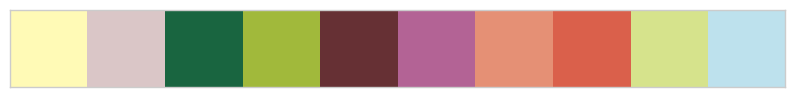

In [5]:
# # custom color map that paints classes in an intuitive way
# # e.g., forests in dark green, parks in light green etc
# cmap = plt.get_cmap("cubehelix")
# cmap = matplotlib.colors.ListedColormap(sns.color_palette("cubehelix", 20))
# label_colors = {i:cmap(i / float(len(myticks)-1)) for i in myticks}
# class_colors = {label2class[k] if k in label2class else "Not Classified":v for k,v in label_colors.iteritems()}

# original colormap from Urban Atlas
class_colors_rgb = [
    ('Continuous Urban Fabric (S.L. > 80%)', (102, 48, 52)),
    ('Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)', (167, 40, 49)),
    ('Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)', (218, 96, 75)),
    ('Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)', (229, 144, 117)),
    ('Discontinuous Very Low Density Urban Fabric (S.L. < 10%)', (249, 171, 174)),
    ('Isolated Structures', (184, 117, 98)),
    ('Industrial, commercial, public, military and private units', (179, 99, 149)),
    ('Fast transit roads and associated land', (221, 110, 47)),
    ('Other roads and associated land', (236, 174, 128)),
    ('Railways and associated land', (119, 119, 118)),
    ('Port areas', (215, 187, 208)), 
    ('Airports', (218, 198, 199)),
    ('Mineral extraction and dump sites', (135, 100, 83)),
    ('Construction sites', (193, 161, 113)),
    ('Land without current use', (134, 88, 79)),
    ('Green urban areas', (161, 185, 59)),
    ('Sports and leisure facilities', (214, 227, 140)), 
    ('Agricultural + Semi-natural areas + Wetlands', (255, 250, 182)),
    ('Forests', (25, 101, 64)),
    ('Water bodies', (189, 225, 237)),
    ('Not Classified', (203, 204, 203))
]
class_colors_all = {c:(np.array(v)/float(255)).tolist() + [1.0] for c,v in class_colors_rgb}

consolidate_classes = {
    "Continuous Urban Fabric (S.L. > 80%)":"High Density Urban Fabric",
     "Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)":"High Density Urban Fabric",
     "Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)":"Medium Density Urban Fabric",
     "Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)":"Low Density Urban Fabric",
     "Discontinuous Very Low Density Urban Fabric (S.L. < 10%)":"Low Density Urban Fabric"
}
classes_consolidate = {v:[x for x in consolidate_classes.keys() if consolidate_classes[x] == v] \
                       for k,v in consolidate_classes.iteritems()}

label_colors = {i:class_colors_all[classes_consolidate[label2class[i]][0] \
                                   if label2class[i] in classes_consolidate else label2class[i]] \
                for i in range(N_CLASSES)}
class_colors = {c:v for c,v in zip(classes, label_colors.values())}

cmap = matplotlib.colors.ListedColormap([class_colors[c] for c in classes])

sns.palplot(sns.color_palette([v for c, v in label_colors.iteritems()]))

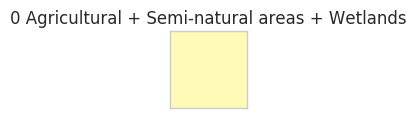

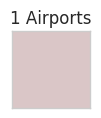

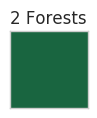

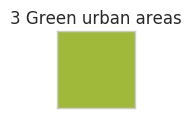

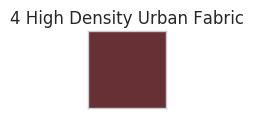

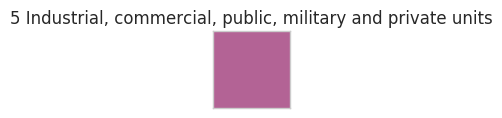

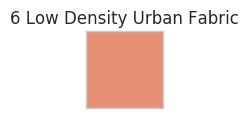

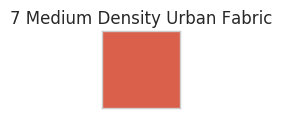

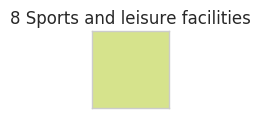

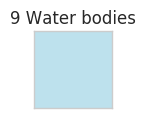

In [6]:
for i in range(N_CLASSES):
    sns.palplot(sns.color_palette([cmap(i)]))
    plt.title("%d %s" %(i, classes[i]))

In [7]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s, target_len=12):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=target_len).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


In [8]:
# cities = ["bucuresti", "berlin", "barcelona", "paris", "athina", \
#           "firenze", "dublin", "london", "tallinn", "bremen"]
cities = ["athina", "berlin", "bucuresti", "tallinn", "barcelona", "dublin"]
experiments = [[x] for x in cities] + [list(set(cities)-set([c])) for c in cities]

data_path = "/home/adalbert/data/urban-atlas/extracted-data/"

# Set up sources : models, data


In [9]:
checkpoints = glob.glob("*checkpoint.h5")
checkpoints = [(f, f.split("-")[0], f.split("-")[2], float(f.split("-")[3])) for f in checkpoints]
checkpoints = pd.DataFrame(checkpoints, columns=["checkpoint", "architecture", "city", "val acc"])
checkpoints = checkpoints.groupby(["architecture", "city"])\
                           .apply(lambda x: x.sort('val acc', ascending=False)[["checkpoint","val acc"]].iloc[0])
checkpoints.reset_index(inplace=True)

stats_df = checkpoints.drop("checkpoint",1).pivot(index="architecture", columns="city")
stats_df.columns = stats_df.columns.droplevel(0)

stats_df.reset_index().to_latex("performance.tex", index=False, index_names=False)

In [10]:

stats_df.reset_index()

city,architecture,athina,barcelona,berlin,berlin+athina+dublin+tallinn+barcelona,berlin+bucuresti+dublin+tallinn+barcelona,bucuresti,bucuresti+athina+dublin+tallinn+barcelona,bucuresti+berlin+athina+dublin+barcelona,bucuresti+berlin+athina+dublin+tallinn,bucuresti+berlin+athina+tallinn+barcelona,dublin,tallinn
0,resnet50,0.81,0.74,0.71,0.68,0.70,0.89,0.72,0.69,0.69,0.64,0.76,0.69
1,vgg16,0.79,0.69,0.68,0.64,0.68,0.88,0.67,0.64,0.66,0.66,0.75,0.67


In [11]:
def get_grid_sources(cities):
    files = np.array([f for c in cities for f in glob.glob(data_path + "%s/img/*/*.jpg"%c)])
    files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
    files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
    files_df['city'] = files_df['filename'].apply(lambda x: x.split("/")[-4])
    files_df['phase'] = files_df['filename'].apply(lambda x: "validation" if "grid" in x else "training")
    files_df['class'] = files_df['class'].apply(
        lambda x: consolidate_classes[x] if x in consolidate_classes else x)
    files_df = files_df[files_df['class'].isin(classes)]
    files_grid_df = files_df[files_df['phase']=='validation']
    return files_grid_df

In [12]:
files_df = get_grid_sources(experiments[0])
print experiments[0], len(files_df)

['athina'] 8371


# Compute performance metrics on test data

In [13]:
def compute_predictions(model, df, batch_size=100):
    sources = zip(df['filename'].values, df['class'].values)
    n_chunks = int(np.ceil(len(sources) / batch_size))
    chunks = np.array_split(sources, n_chunks)
    y_pred = []
    for idx, chunk in enumerate(chunks):
        clear_output(wait=True)
        print "Chunk %d / %d" % (idx, n_chunks)
        images = []
        for s in chunk:
            filename, label = s
            img = ku.load_and_preprocess(filename) * 1.0/255.0
            images.append(img)
        images = np.array(images)
        y_pred.append(model.predict(images, batch_size=len(images)))
    y_pred = np.vstack(y_pred)
    return y_pred


def compute_predictions_for_checkpoint(model_file, df, batch_size=100):
    with tf.device('/cpu:0'):
        model = keras.models.load_model(model_file)

    # compile model
    from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
    model.compile(loss='categorical_crossentropy', \
                  metrics=['accuracy'],\
                  optimizer=Adadelta(lr=0.01))
    return compute_predictions(model, df, batch_size=batch_size)
   
    
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_performance_for_checkpoint(model_file, df, \
                                       n_samples=1000, batch_size=100):
    if n_samples is None:
        n_samples = len(df)
    else:
        df = ku.balanced_df(df, nrows=n_samples)
    print len(df)
            
    # one-hot encoding of ground truth labels
    y_true_class = df['class'][:n_samples].apply(lambda x: class2label[x]).values
    y_true = np.zeros((len(y_true_class), len(class2label)))
    y_true[np.arange(len(y_true)), y_true_class] = 1
    
    y_pred = compute_predictions_for_checkpoint(model_file, df, \
                                                batch_size=batch_size)
    y_pred_class = y_pred.argmax(1) 
    
    return df.index[:n_samples], y_true, y_true_class, y_pred, y_pred_class

In [14]:
from sklearn.metrics import confusion_matrix

def compute_plot_confusion_matrix(y_true_class, y_pred_class, classes):

    confmat = confusion_matrix(y_true_class, y_pred_class, labels=range(N_CLASSES))
    confmat = confmat / confmat.sum(0).astype(float)
    df_cm = pd.DataFrame(confmat, index = [split_str(c) for c in classes],
                          columns = [split_str(c) for c in classes])

    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    plt.figure(figsize = (12,10))
    sns.heatmap(df_cm, annot=True, fmt=".2f")
    
    return confmat

In [15]:
checkpoints

,architecture,city,checkpoint,val acc
0,resnet50,athina,resnet50-urbanatlas-athina-0.81-checkpoint.h5,0.81
1,resnet50,barcelona,resnet50-urbanatlas-barcelona-0.74-checkpoint.h5,0.74
2,resnet50,berlin,resnet50-urbanatlas-berlin-0.71-checkpoint.h5,0.71
3,resnet50,berlin+athina+dublin+tallinn+barcelona,resnet50-urbanatlas-berlin+athina+dublin+talli...,0.68
4,resnet50,berlin+bucuresti+dublin+tallinn+barcelona,resnet50-urbanatlas-berlin+bucuresti+dublin+ta...,0.70
5,resnet50,bucuresti,resnet50-urbanatlas-bucuresti-0.89-checkpoint.h5,0.89
6,resnet50,bucuresti+athina+dublin+tallinn+barcelona,resnet50-urbanatlas-bucuresti+athina+dublin+ta...,0.72
7,resnet50,bucuresti+berlin+athina+dublin+barcelona,resnet50-urbanatlas-bucuresti+berlin+athina+du...,0.69
8,resnet50,bucuresti+berlin+athina+dublin+tallinn,resnet50-urbanatlas-bucuresti+berlin+athina+du...,0.69
9,resnet50,bucuresti+berlin+athina+tallinn+barcelona,resnet50-urbanatlas-bucuresti+berlin+athina+ta...,0.64


In [ ]:
model_file = checkpoints['checkpoint'].iloc[0]

y_pred = compute_predictions_for_checkpoint(model_file, files_df, batch_size=100)

In [16]:
# Compute ROC curves

from sklearn.metrics import roc_curve, accuracy_score, precision_score, auc, recall_score, confusion_matrix

def compute_plot_roc_curves(y_true, y_pred, cmap):
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        if np.isnan(fpr[i]).sum()>0 or np.isnan(tpr[i]).sum()>0:
            continue
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})

    plt.figure(figsize=(14,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='avg (micro) AUC = {0:0.2f}'
                   ''.format(roc_auc["micro"]),
             color='black', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='avg (macro)\nAUC = {0:0.2f}'
    #                ''.format(roc_auc["macro"]),
    #          color='k', linestyle=':', linewidth=8)

    roc_auc_class = {label2class[i] if i in label2class else i:v for i,v in roc_auc.iteritems()}

    for i in range(n_classes):
        if np.isnan(roc_auc[i]):
            continue
        plt.plot(fpr[i], tpr[i], color=cmap(i), lw=2, alpha=0.7,
                 label='{0} AUC={1:0.2f}'
                 ''.format(split_str(label2class[i]), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.legend(loc="lower right", ncol=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
    return roc_auc, fpr, tpr

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def compute_plot_precision_recall_curves(y_true, y_pred):
    # Compute Precision-Recall curve
    n_classes = y_true.shape[1]
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
                                                            y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
        y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                         average="micro")
    
    # Plot Precision-Recall curve
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(12,10))
    plt.plot(recall["micro"], precision["micro"], color='k', lw=4,
             label='Avg (area = {0:0.2f})'
                   ''.format(average_precision["micro"]))
    for i in range(N_CLASSES):
        plt.plot(recall[i], precision[i], color=cmap(i), lw=2,
                 label='{0} (area = {1:0.2f})'
                       ''.format(split_str(label2class[i]), average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Urban Atlas: Precision-Recall Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
    plt.show()
    
    return precision, recall

In [21]:
cities

['athina', 'berlin', 'bucuresti', 'tallinn', 'barcelona', 'dublin']

In [25]:
checkpoints_sel

,architecture,city,checkpoint,val acc
0,resnet50,athina,resnet50-urbanatlas-athina-0.81-checkpoint.h5,0.81
1,resnet50,barcelona,resnet50-urbanatlas-barcelona-0.74-checkpoint.h5,0.74
2,resnet50,berlin,resnet50-urbanatlas-berlin-0.71-checkpoint.h5,0.71
3,resnet50,berlin+athina+dublin+tallinn+barcelona,resnet50-urbanatlas-berlin+athina+dublin+talli...,0.68
4,resnet50,berlin+bucuresti+dublin+tallinn+barcelona,resnet50-urbanatlas-berlin+bucuresti+dublin+ta...,0.70
5,resnet50,bucuresti,resnet50-urbanatlas-bucuresti-0.89-checkpoint.h5,0.89
6,resnet50,bucuresti+athina+dublin+tallinn+barcelona,resnet50-urbanatlas-bucuresti+athina+dublin+ta...,0.72
7,resnet50,bucuresti+berlin+athina+dublin+barcelona,resnet50-urbanatlas-bucuresti+berlin+athina+du...,0.69
8,resnet50,bucuresti+berlin+athina+dublin+tallinn,resnet50-urbanatlas-bucuresti+berlin+athina+du...,0.69
9,resnet50,bucuresti+berlin+athina+tallinn+barcelona,resnet50-urbanatlas-bucuresti+berlin+athina+ta...,0.64


In [ ]:
if os.path.exists("performance_metrics.pickle.gz"):
    with gzip.open("performance_metrics.pickle.gz", "r") as f:
        (auc_dict, stats_dict) = pickle.load(f)
else:
    auc_dict = {}
    stats_dict = {}    
    
for test_city in cities:
    test_df = pd.read_csv("./%s-test.csv"%test_city)
    
    checkpoints_sel = checkpoints[(checkpoints["architecture"]=='resnet50') & 
                                  (~(checkpoints['city'].str.contains(test_city)) | (checkpoints['city']==test_city))]

    for i,r in checkpoints_sel.iterrows():
        model_file = r['checkpoint']
        train_city = r['city']
        key = (r['architecture'], train_city, test_city)
        if key in stats_dict:
            print key, "already computed!"
            continue
        
        _, y_true, y_true_class, y_pred, y_pred_class = \
            compute_performance_for_checkpoint(model_file, test_df, \
                                               n_samples=2000, batch_size=100)
        accr = accuracy_score(y_true_class, y_pred_class)
        recl = recall_score(y_true_class, y_pred_class, average="macro")
        prec = precision_score(y_true_class, y_pred_class, average="weighted")

        title_str = "%s : %s --> %s" % (r['architecture'], train_city, test_city)
        print title_str
        print "Accuracy:  %2.3f" % accr
        print "Precision: %2.3f" % prec
        print "Recall:    %2.3f" % recl
        
        confmat = compute_plot_confusion_matrix(y_true_class, y_pred_class, classes)
        plt.title(title_str, fontsize=18)
        plt.savefig(plotdir + "/%s_confmat.pdf"%title_str.replace(" ","_"), bbox_inches='tight')
        
        myauc, _, _ = compute_plot_roc_curves(y_true, y_pred, cmap)
        plt.title(title_str, fontsize=18)
        plt.savefig(plotdir + "/%s_roc.pdf"%title_str.replace(" ","_"), bbox_inches='tight')

        auc_dict[key] = myauc
        stats_dict[key] = (accr, prec, recl)

Chunk 19 / 20
resnet50 : berlin+athina+dublin+tallinn+barcelona --> bucuresti
Accuracy:  0.637
Precision: 0.679
Recall:    0.447
2000


In [36]:
with gzip.open("performance_metrics.pickle.gz", "w") as f:
    pickle.dump([auc_dict, stats_dict], f)


In [37]:
stats_dict.keys()

[('resnet50', 'berlin', 'berlin'),
 ('resnet50', 'berlin', 'athina'),
 ('resnet50', 'tallinn', 'dublin'),
 ('resnet50', 'berlin', 'dublin'),
 ('resnet50', 'barcelona', 'bucuresti'),
 ('resnet50', 'athina', 'barcelona'),
 ('resnet50', 'barcelona', 'barcelona'),
 ('resnet50', 'bucuresti', 'bucuresti'),
 ('resnet50', 'athina', 'berlin'),
 ('resnet50', 'athina', 'tallinn'),
 ('resnet50', 'dublin', 'bucuresti'),
 ('resnet50', 'tallinn', 'berlin'),
 ('resnet50', 'tallinn', 'barcelona'),
 ('resnet50', 'tallinn', 'athina'),
 ('resnet50', 'berlin', 'tallinn'),
 ('resnet50', 'berlin+athina+dublin+tallinn+barcelona', 'bucuresti'),
 ('resnet50', 'berlin', 'bucuresti'),
 ('resnet50', 'barcelona', 'athina'),
 ('resnet50', 'athina', 'dublin'),
 ('resnet50', 'bucuresti+berlin+athina+dublin+tallinn', 'barcelona'),
 ('resnet50', 'dublin', 'athina'),
 ('resnet50', 'bucuresti+berlin+athina+dublin+barcelona', 'tallinn'),
 ('resnet50', 'bucuresti', 'berlin'),
 ('resnet50', 'barcelona', 'berlin'),
 ('resnet5

In [64]:
transf_res.columns = 

test,athina,barcelona,berlin,bucuresti,dublin,tallinn
index,,,,,,
all,0.5165,0.4610,0.4740,0.6375,0.4610,0.4415
athina,0.8155,0.4480,0.3345,0.5170,0.3150,0.2830
barcelona,0.5350,0.7605,0.3240,0.5220,0.2880,0.2215
berlin,0.4085,0.3775,0.6975,0.6495,0.5185,0.4600
bucuresti,0.3940,0.3360,0.4130,0.8935,0.3825,0.3895
dublin,0.4550,0.3760,0.4555,0.5540,0.7455,0.3645
tallinn,0.3305,0.3360,0.4010,0.5405,0.3790,0.7405


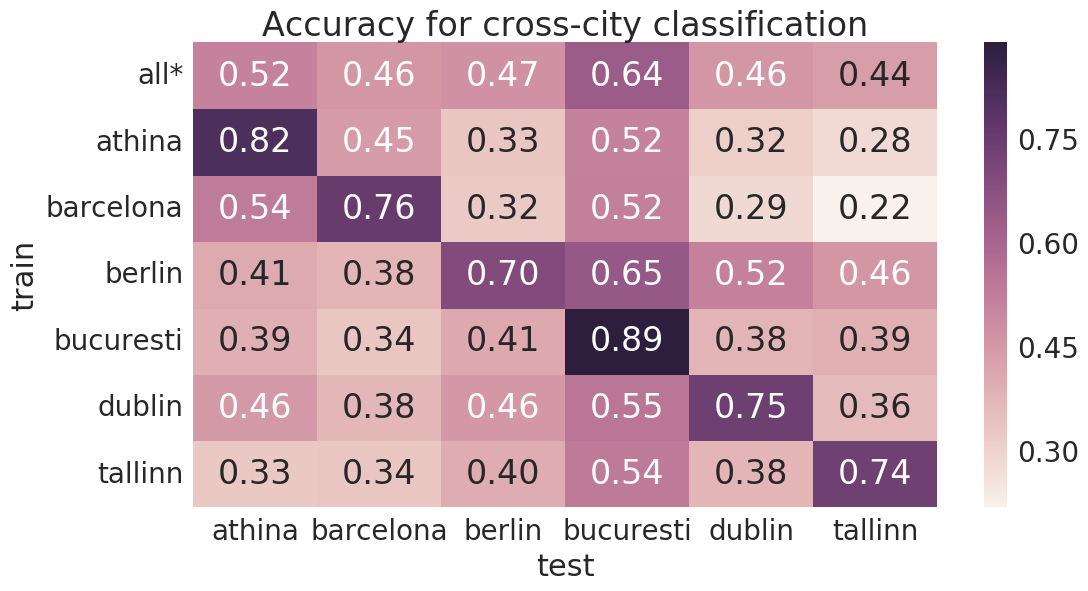

In [71]:
transf_res = pd.DataFrame(stats_dict)['resnet50'].iloc[0]
transf_res = pd.DataFrame(transf_res).reset_index()\
                .rename(columns={"level_0":"train", "level_1":"test"})\
                .pivot("train", "test")
transf_res.columns = transf_res.columns.droplevel(0)
transf_res.index = ["all*" if '+' in c else c for c in transf_res.index]
transf_res = transf_res.fillna(0).reset_index().groupby("index").sum()
del transf_res.index.name

transf_res = transf_res.sort_index(0).sort_index(1)

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
plt.figure(figsize = (12,6))
sns.heatmap(transf_res, annot=True, fmt=".2f")
plt.title("Accuracy for cross-city classification")
plt.ylabel("train")

# Compute & plot comparison between ground truth rasters and predicted rasters

In [72]:
import re

def get_grid_coords(filename):
    reg_i = r"(grid-[i]+)(\d+)"
    reg_j = r"(grid-[j]+)(\d+)"
    match_i = re.search(reg_i, filename)
    match_j = re.search(reg_j, filename)
    i = int(filename[match_i.start():match_i.end()].replace("grid-i",""))
    j = int(filename[match_j.start():match_j.end()].replace("grid-j",""))
    return i,j

def predict_raster_for_checkpoint(model_file, df, batch_size=100):
    raster = np.zeros((100,100,N_CLASSES))
    coords = df['filename'].apply(lambda f: get_grid_coords(f))
    y_pred = compute_predictions_for_checkpoint(model_file, df, batch_size=100)
    for (i,j), pred in zip(coords, y_pred):
        raster[i,j,:] = pred
    return raster

#### Predict raster map using own model

In [101]:
rasters_pred = {}
maps_pred = {}
for c in cities:
    grid_loc_df = get_grid_sources([c])
    model_file = checkpoints['checkpoint'][(checkpoints.city==c) & (checkpoints.architecture=='resnet50')].iloc[0]
    rasters_pred[c] = predict_raster_for_checkpoint(model_file, grid_loc_df)
    maps_pred[c] = rasters_pred[c].argmax(2)
    
with gzip.open("rasters_25_pred.pickle.gz", "w") as f:
    pickle.dump([rasters_pred, maps_pred], f)
    
# with gzip.open("rasters_25_pred.pickle.gz", "r") as f:
#     rasters_pred, maps_pred = pickle.load(f)

Chunk 80 / 81


#### Predict raster map using "all-but" model

In [102]:
rasters_pred_cross = {}
maps_pred_cross = {}
for c in cities:
    grid_loc_df = get_grid_sources([c])
    model_file = checkpoints['checkpoint'][(checkpoints.city.str.contains("\+") & ~(checkpoints.city.str.contains(c)))\
                                            & (checkpoints.architecture=='resnet50')].iloc[0]
    rasters_pred_cross[c] = predict_raster_for_checkpoint(model_file, grid_loc_df)
    maps_pred_cross[c] = rasters_pred_cross[c].argmax(2)
    
with gzip.open("rasters_25_pred_cross.pickle.gz", "w") as f:
    pickle.dump([rasters_pred_cross, maps_pred_cross], f)
    
# with gzip.open("rasters_25_pred_cross.pickle.gz", "r") as f:
#     rasters_pred_cross, maps_pred_cross = pickle.load(f)

Chunk 80 / 81


#### Load and format ground truth rasters

In [103]:
# load ground truth raster

def load_ground_truth_raster(city):
    with np.load("%s/%s/ground_truth_class_raster_25.npz"%(data_path, city)) as data:
        raster_true_orig = data['arr_0']

    # consolidate classes 
    raster_true = np.zeros(raster_true_orig.shape[:-1] + (N_CLASSES,))
    for i,c in label2class.iteritems():
        if c in classes_consolidate:
            i0 = [class2label_all[x] for x in classes_consolidate[c]]
        else:
            i0 = [class2label_all[c]]
        raster_true[:,:,i] = raster_true_orig[:,:,i0].max(2)

    mask = (raster_true_orig>0).sum(2)==0
    map_classified = raster_true.argmax(2)
    map_classified[mask] = 10
    
    return raster_true, mask, map_classified

In [104]:
rasters_true = {}
maps_true = {}
masks = {}
for c in cities:
    raster_true, mask, map_classified = load_ground_truth_raster(c)
    masks[c] = mask
    rasters_true[c] = raster_true
    maps_true[c] = map_classified

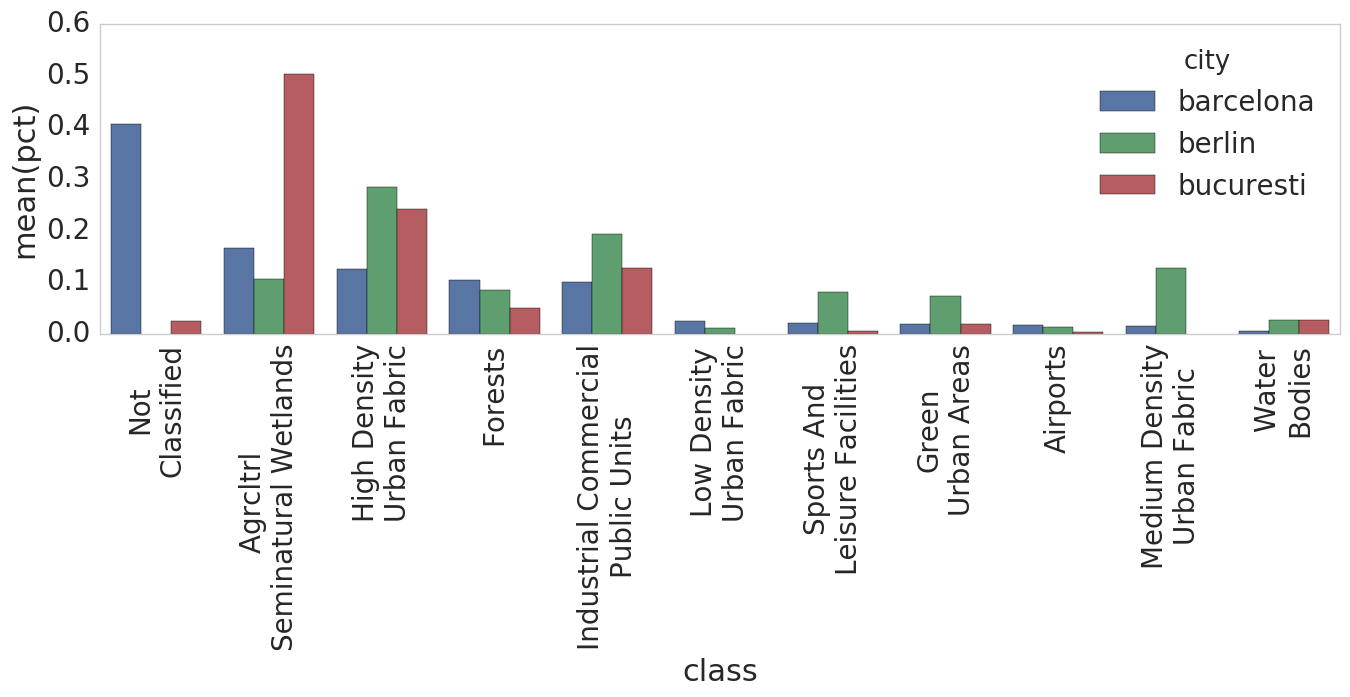

In [165]:
classes_pct = pd.DataFrame({c:[label2class[x] if x in label2class else "Not Classified" for x in v.flatten()] \
                            for c,v in maps_true.iteritems()})
classes_pct = pd.melt(classes_pct[["barcelona", "berlin", "bucuresti"]]).rename(columns={"variable":"city"})
classes_pct = pd.DataFrame(classes_pct.groupby("city").apply(lambda x: x['value'].value_counts() / (100.0*100.0)))\
                .reset_index().rename(columns={"level_1":"class", "value":"pct"})
classes_pct['class'] = classes_pct['class'].apply(lambda x: split_str(x))

fig, ax = plt.subplots(figsize=(16,4))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
pl = sns.barplot(data=classes_pct, \
                 x="class", y="pct", hue="city", estimator=np.mean,\
                 ax=ax)
for item in pl.get_xticklabels():
    item.set_rotation(90)

#### Plot examples of ground truth & predicted rasters

In [105]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_raster_classes(raster):
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    fig = plt.figure(figsize = (14,3))
    gs1 = gridspec.GridSpec(1, 10)
    gs1.update(wspace=0.7, hspace=0.00, top=0.5, bottom=0.00) # set the spacing between axes. 

    for n in range(raster.shape[2]):
        ax = plt.subplot(gs1[n])
        ax.imshow(raster[:,:,n])
        ax.set_title(split_str(label2class[n], 10))
        ax.set_yticks([])    
        ax.set_xticks([])
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0.5, hspace=0)

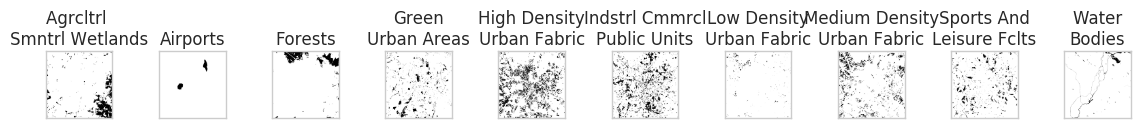

In [106]:
plot_raster_classes(rasters_true['berlin'])

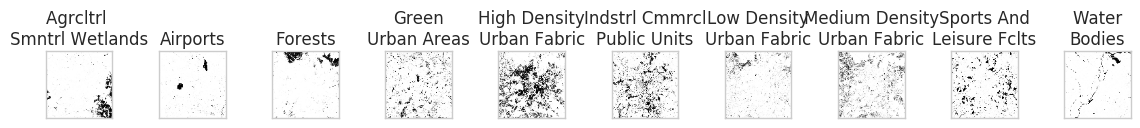

In [107]:
plot_raster_classes(rasters_pred['berlin'])

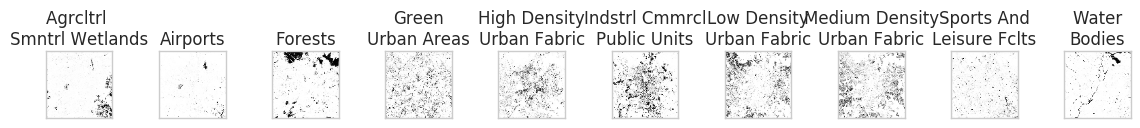

In [110]:
plot_raster_classes(rasters_pred_cross['berlin'])

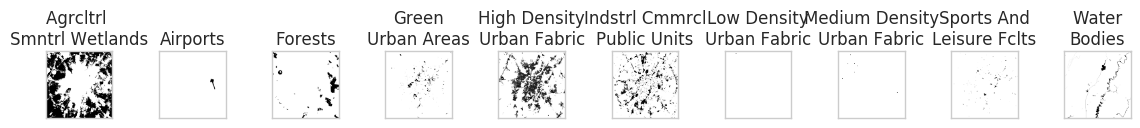

In [111]:
plot_raster_classes(rasters_true['bucuresti'])

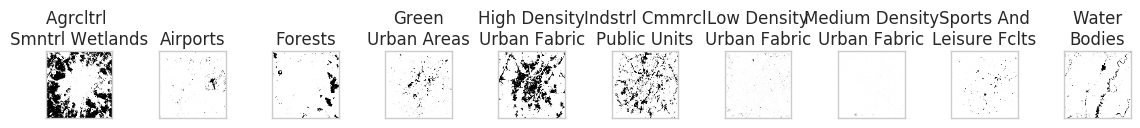

In [112]:
plot_raster_classes(rasters_pred['bucuresti'])

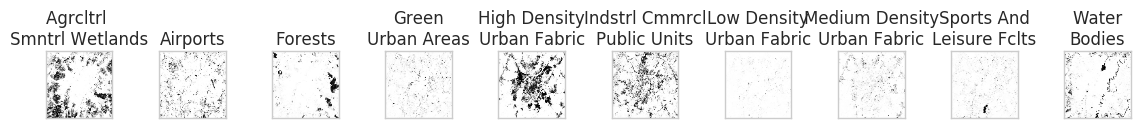

In [113]:
plot_raster_classes(rasters_pred_cross['bucuresti'])

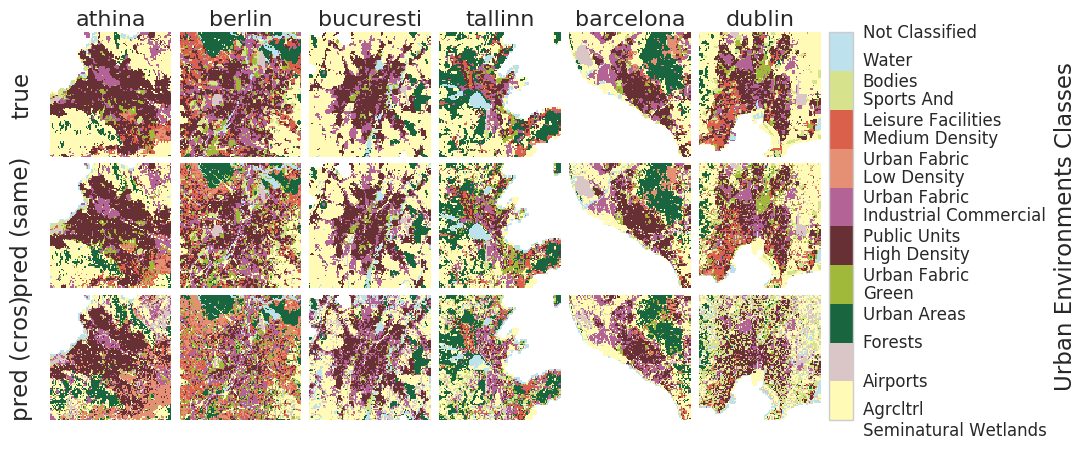

In [122]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(30,5))
width_ratios = [5 for _ in range(len(cities))] + [1] + \
                [5 for _ in range(len(cities))] + [1] + [5 for _ in range(len(cities))] + [1.5]
gs = matplotlib.gridspec.GridSpec(3, len(cities)+1, width_ratios=width_ratios, wspace=0.025, hspace=0.05)
ax_cbar = plt.subplot(gs[:,-1])

for i, c in enumerate(cities):
    top_ax = plt.subplot(gs[0,i])
    mid_ax = plt.subplot(gs[1,i])
    bot_ax = plt.subplot(gs[2,i])
    sns.heatmap(maps_true[c], cmap=cmap, cbar=False, mask=masks[c], ax=top_ax)
    sns.heatmap(maps_pred[c], cmap=cmap, cbar=False, mask=masks[c], ax=mid_ax)
    sns.heatmap(maps_pred_cross[c], cmap=cmap, cbar=False, mask=masks[c], ax=bot_ax)
    top_ax.set_xticklabels([])
    top_ax.set_yticklabels([])
    mid_ax.set_xticklabels([])
    mid_ax.set_yticklabels([])
    bot_ax.set_xticklabels([])
    bot_ax.set_yticklabels([])
    top_ax.set_title(c, fontsize=16)
    if i == 0:
        top_ax.set_ylabel("true")
        mid_ax.set_ylabel("pred (same)")
        bot_ax.set_ylabel("pred (cros)")

    
myticks = range(N_CLASSES) + [10]
myticklabels = [split_str(c) for c in classes] + ["Not Classified"]

cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                boundaries=myticks,
                                ticks=myticks,
                                orientation="vertical",
                                ticklocation="right",
                                spacing='uniform')
cb3.set_label('Urban Environments Classes')
# cb3.ax.set_yticks(myticks)
cb3.ax.set_yticklabels(myticklabels, fontsize=12)

plt.show()

# Compute raster performance metrics

In [ ]:
def raster_to_vector(raster, mask):
    y = raster.reshape((-1,raster.shape[-1]))
    if mask is not None:
        y_mask = mask.reshape((-1,1)).squeeze()
    else:
        y_mask = np.zeros(len(y_true)).astype(bool)
    y = y[~y_mask]
    return y

In [ ]:
y_pred = raster_to_vector(rasters_pred["bucuresti"], masks['bucuresti'])
y_true = raster_to_vector(rasters_true["bucuresti"], masks['bucuresti'])


In [ ]:
_ = compute_plot_confusion_matrix(y_true.argmax(1), y_pred.argmax(1), classes)

# Distribution similarities -- later on?

In [ ]:
from scipy.stats import entropy
from sklearn.metrics import roc_curve, accuracy_score, precision_score, auc, recall_score, confusion_matrix
from sklearn.preprocessing import label_binarize

def compute_distribution_similarity(y_pred, y_true):
    y_pred = raster_pred.reshape((-1,raster_pred.shape[-1]))
    y_true = raster_true.reshape((-1,raster_true.shape[-1]))
    if mask is not None:
        y_mask = mask.reshape((-1,1)).squeeze()
    else:
        y_mask = np.zeros(len(y_true)).astype(bool)
    y_pred = y_pred[~y_mask]
    y_true = y_true[~y_mask]
    y_pred_class = y_pred.argmax(1)
    y_true_class = y_true.argmax(1)
    N,C = y_true.shape
    
    # compare distributions: KL divergence
    kld = np.array(map(lambda p,q: entropy(p,q), y_pred, y_true))
    kld = kld[~np.isinf(kld)]
    kld_df= pd.DataFrame({"kld":kld[~y_mask], "true class":y_true_class[~y_mask]})
    kld_class = kld_df.groupby("true class").apply(np.mean)
    
    # compare predictions
    confmat = confusion_matrix(y_true_class, y_pred_class)
    
    return kld.mean(), kld_class

# compute KL divergence, map back to raster
# the lower, the better
kld    = np.array(map(lambda p,q: entropy(p,q + 1e-8), y_pred, y_true))
kld[np.isinf(kld)] = 0
kld_map = kld.reshape(raster_all.shape[:-1])

# compute chi-squared statistic & map back to raster
# the lower, the better
chi2 = np.array(map(lambda p,q: chisquare(p,q + 1e-8).statistic, \
                   y_pred, y_true))
chi2[np.isinf(chi2)] = 0
chi2_map = chi2.reshape(raster_all.shape[:-1])
                 
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(kld_map)
ax[0].axis("off")
ax[0].set_title("KL Divergence")

ax[1].imshow(chi2_map)
ax[1].axis("off")
ax[1].set_title("Chi-squared statistic")

y_pred = raster_all.reshape((-1,raster_all.shape[-1]))
y_true = raster_true.reshape((-1,raster_true.shape[-1]))
y_mask = mask.reshape((-1,1)).squeeze()